### Classification Solutions

In [1]:
# Importing the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import ( ModelSpec as MS, summarize )
from ISLP import confusion_table
from sklearn.discriminant_analysis import \
(LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
data = load_data("Weekly")
data.head(), data.shape

(   Year   Lag1   Lag2   Lag3   Lag4   Lag5    Volume  Today Direction
 0  1990  0.816  1.572 -3.936 -0.229 -3.484  0.154976 -0.270      Down
 1  1990 -0.270  0.816  1.572 -3.936 -0.229  0.148574 -2.576      Down
 2  1990 -2.576 -0.270  0.816  1.572 -3.936  0.159837  3.514        Up
 3  1990  3.514 -2.576 -0.270  0.816  1.572  0.161630  0.712        Up
 4  1990  0.712  3.514 -2.576 -0.270  0.816  0.153728  1.178        Up,
 (1089, 9))

`Weekly` is similar to `Smarket` but it has around 1089 entries from the beginning of 1990 to end of 2010.

In [3]:
data.loc[:, "Direction"].value_counts()

Direction
Up      605
Down    484
Name: count, dtype: int64

In [4]:
data_wo_direction = data.loc[:, "Year" : "Today"]
data_wo_direction.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


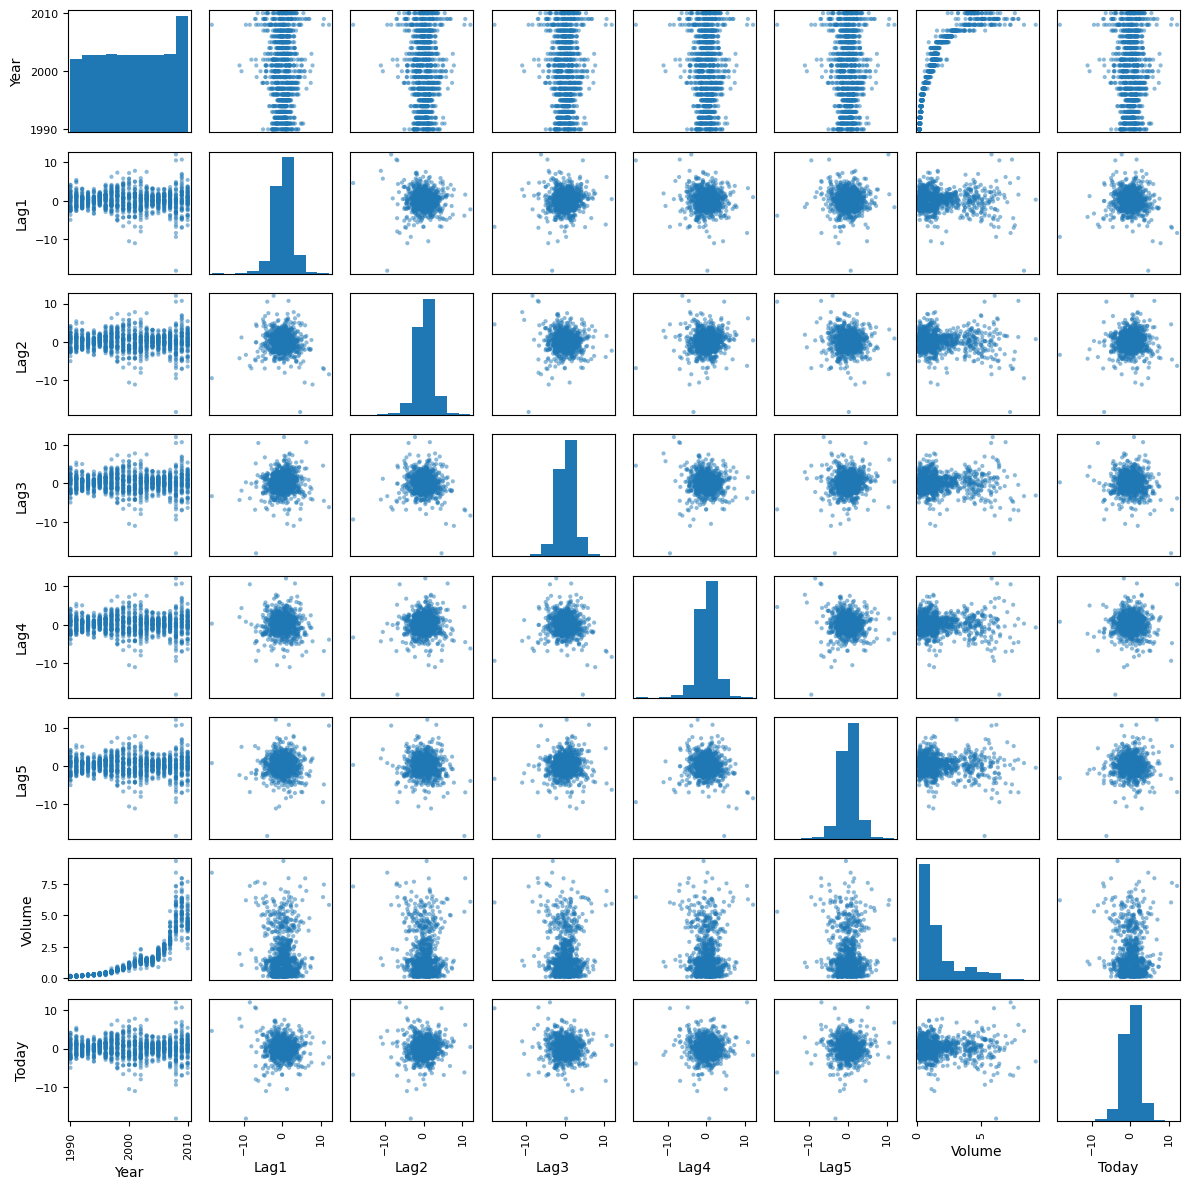

In [5]:
# Some graphical summaries - best corr matrix?
pd.plotting.scatter_matrix(data, figsize = (12,12))
plt.tight_layout()
plt.show()

I think the volume is increasing non linearly with year. Rest pretty much of no use i think

In [6]:
# Direction as a response & five lag variables + volume
vals = data.columns.drop(["Year", "Today", "Direction"])
x = MS(vals).fit_transform(data)
y = data.loc[:,"Direction"] == "Up"

logit_model = sm.GLM(y,x, family = sm.families.Binomial()).fit()
summarize(logit_model)

,coef,std err,z,P>|z|
intercept,0.2669,0.086,3.106,0.002
Lag1,-0.0413,0.026,-1.563,0.118
Lag2,0.0584,0.027,2.175,0.030
Lag3,-0.0161,0.027,-0.602,0.547
Lag4,-0.0278,0.026,-1.050,0.294
Lag5,-0.0145,0.026,-0.549,0.583
Volume,-0.0227,0.037,-0.616,0.538


Only `Lag1` seems to be significant, maybe because of the correlation one is carrying the weight of the other but there is none correlation. 

In [7]:
# Computing the confusion matrix
probs = logit_model.predict()
labels_pred = np.where(probs >= 0.5, "Up", "Down")
confusion_table(labels_pred, data.loc[:, "Direction"])

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


1. Accuracy : $\frac{54+557}{1089} \approx 0.561 \, (56.1\%)$
2. Precision : $\frac{557}{557+430} \approx 0.564 \, (56.4\%)$
3. Recall : $\frac{557}{557 + 48} \approx 0.921 \, (92.1\%)$
4. Specificity : $\frac{54}{54+430} \approx 0.111 \, (11.1\%)$

Inference : <br> 
- Model has very good recall, it can identify actual positives as positives around 92% of time.
- Very low specificity, it cannot predict true negatives well.
- Accuracy is somewhere around 56.1%, expect it to decrease with testing dataset
- Precision is somewhere around 56.4%, around 56.4% of times model is correctly predicting the true positives, high rate due to large number of false positives.

Though the model is good at identifying positives but due to large number of false positives it cannot predict true positives well

In [8]:
# d - training and testing data
train = data.Year < 2008
x = MS(["Lag2"]).fit_transform(data)
x_train, x_test = x[train], x[~train]
y_train, y_test = y[train], y[~train]

In [9]:
# Fitting the model
model_logit = sm.GLS(y_train, x_train).fit()
pred = model_logit.predict(x_test)
predicts = np.where(pred >= 0.5, "Up", "Down")
y_test = np.where(y_test == True, "Up", "Down")
confusion_table(predicts, y_test)

Truth,Down,Up
Predicted,,
Down,6,5
Up,66,79


Accuracy = $\frac{6+79}{6+79+66+5} \approx 0.544 \, (54.4\%)$ Performs similar to the above model with high recall and low specificity.

In [10]:
# Linear discriminant analysis
lda = LDA(store_covariance = True)
x = data.loc[:, ["Lag2"]]
x_train, x_test = x[train], x[~train]


In [11]:
y = data.loc[:, "Direction"]
y_training = y[train]
lda.fit(x_train, y_training)

LinearDiscriminantAnalysis(store_covariance=True)

In [12]:
lda.means_ , lda.classes_ , lda.scalings_

(array([[0.07329612],
        [0.27110173]]),
 array(['Down', 'Up'], dtype='<U4'),
 array([[0.48766688]]))

$\hat{\pi_{False}} = 0.0732 $ <br>
$\hat{\pi_{True}} = 0.27110 $ <br>
Closer the means harder are the classes to separate <br>
The decision boundary is $0.487 \cdot \text{lag}_2$

In [13]:
lda_pred = lda.predict(x_test)
confusion_table(lda_pred, y_test)

Truth,Down,Up
Predicted,,
Down,6,5
Up,66,79


Accuracy = $\frac{5 + 79}{ 66 + 5 + 79 + 6} \approx 0.5448 \, (54.48\%) $ Ahh the accuracy didn't improve from logisitic regression

In [14]:
qda = QDA(store_covariance = True)
qda.fit(x_train, y_training)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [15]:
qda.means_, qda.classes_, qda.scalings_

(array([[0.07329612],
        [0.27110173]]),
 array(['Down', 'Up'], dtype=object),
 [array([3.54818021]), array([4.72392308])])

Interesting to see the scaling with $\text{False} = 3.54$ and $\text{True} = 4.72$ It means that it is better to classify the true classes

In [16]:
qda_pred = qda.predict(x_test)
confusion_table(qda_pred, y_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,72,84


It predicted only true values. 
Accuracy = $\frac{84}{84+72} \approx 0.534 \, (53.4\%)$ <br> This is _even_ better than LDA - separate covariances doesn't suit ig. 

In [17]:
# Naive bayes predictions
nb = GaussianNB()
nb.fit(x_train, y_training)

GaussianNB()

In [18]:
nb.classes_, nb.class_prior_, nb.theta_, nb.var_

(array(['Down', 'Up'], dtype='<U4'),
 array([0.44158628, 0.55841372]),
 array([[0.07329612],
        [0.27110173]]),
 array([[3.53956813],
        [4.71485605]]))

Means seems to be pretty similar with rest of the methods - probably going to yield the same results. The prior probability for `Down` is 44.1% and `Up` is 55.8%

In [19]:
preds = nb.predict(x_test)
confusion_table(preds, y_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,72,84


There seems to be a data problem, these are only predicting `Up` with accuracy somewhere around 53.4% 

In [21]:
# KNN with K = 1
knn1 = KNeighborsClassifier(n_neighbors = 1)
y = data.Direction
knn1.fit(x_train, y_training)
pred = knn1.predict(x_test)
confusion_table(pred, y_test)

Truth,Down,Up
Predicted,,
Down,30,38
Up,42,46


Accuracy is around 48% performs worse. Best result is logistic regression for sure. 

### Question 14

Goal : Model to predict whether a given car gets high or low gas mileage based on `Auto` data set

In [24]:
data = load_data("Auto")
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


In [35]:
data["mpg01"] = np.where(data["mpg"] >= np.median(data["mpg"]), 1,0)
np.median(data["mpg"]), data.shape

(22.75, (392, 9))

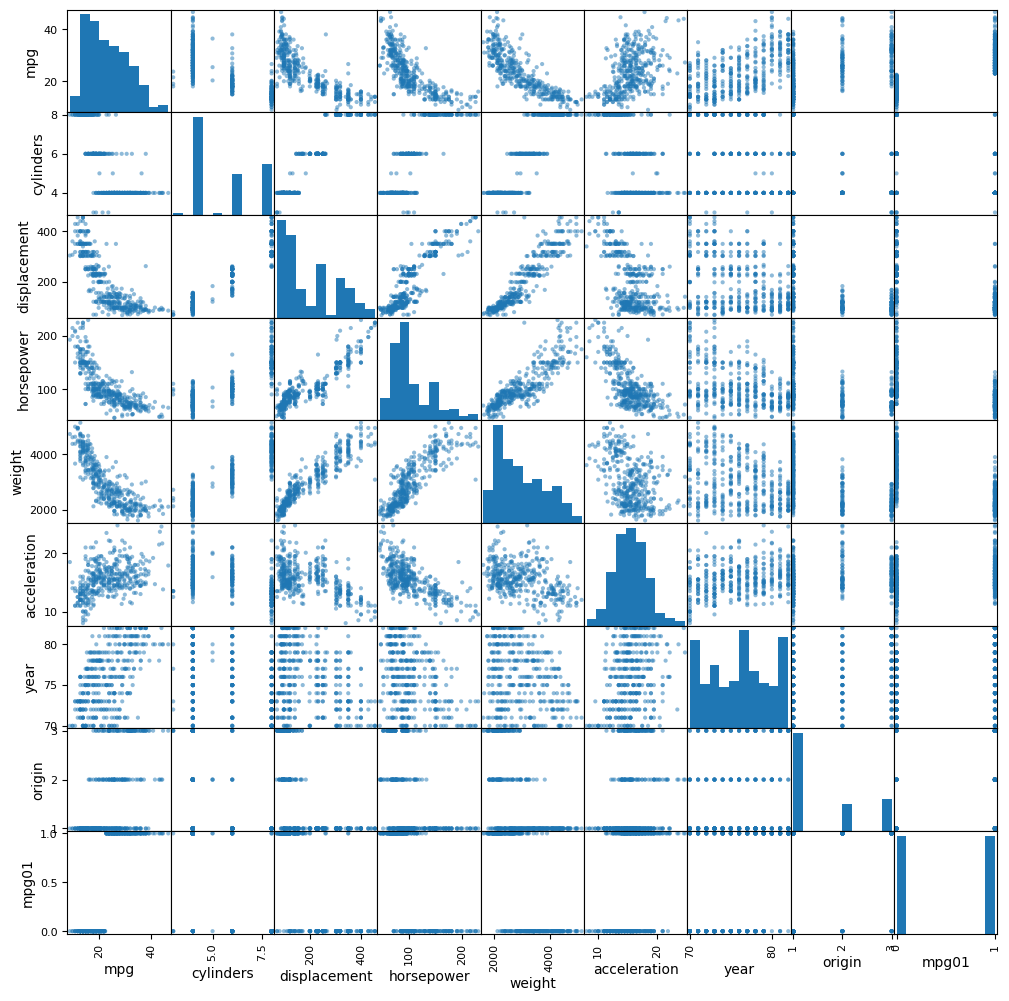

In [34]:
# Exploring the data graphically
pd.plotting.scatter_matrix(data, figsize = (12,12))
plt.show()

#### Understanding the data graphically
_Goal is to predict high or low mileage_ 

1. `Mileage` seems to have -ve non-linear relationship with `displacement`, `horsepower` & `weight`
2. `Mileage` seems to have +ve non-linear relationship with `accelaration` & also depends on the year of the vehicle as well
3. Particular cylinders' capacity supporting displacement, horsepower and weight
4. Seems like weight, displacement and horsepower are correlated positive.
5. Doesn't seem too much, but origin might also play a role for determining the mileage, seems like the average of the origin determines the mileage

Year cannot be used as to create training and testing splits .

In [58]:
# Splitting the data into training and testing set
(x_train, x_test) = train_test_split(data, test_size = 125, random_state = 0)
y_train = x_train["mpg01"]
y_test = x_test["mpg01"]

x_training = x_train.loc[:,data.columns.drop(["mpg", "mpg01"])]
x_testing = x_test.loc[:,data.columns.drop(["mpg", "mpg01"])]

0      Down
1      Down
2        Up
3        Up
4        Up
       ... 
928      Up
929    Down
930      Up
931    Down
932    Down
Name: Direction, Length: 933, dtype: category
Categories (2, object): ['Down', 'Up']

In [76]:
# Performing LDA
lda = LDA(store_covariance = True)
lda_model = lda.fit(x_training, y_train)
preds = lda_model.predict(x_testing)
confusion_table(y_test.values, preds)

Truth,0,1
Predicted,,
0,49,9
1,4,63


In [79]:
lda.means_, lda.classes_, lda.scalings_, lda.priors_

(array([[6.74637681e+00, 2.70108696e+02, 1.28173913e+02, 3.60846377e+03,
         1.46586957e+01, 7.44057971e+01, 1.16666667e+00],
        [4.14728682e+00, 1.14631783e+02, 7.93100775e+01, 2.32410078e+03,
         1.64255814e+01, 7.76744186e+01, 2.00000000e+00]]),
 array([0, 1]),
 array([[-0.59003122],
        [ 0.00233534],
        [ 0.0132476 ],
        [-0.00130265],
        [ 0.0261843 ],
        [ 0.12835232],
        [ 0.20670078]]),
 array([0.51685393, 0.48314607]))

1. Accuracy : $\frac{49+63}{49 + 63 + 4 + 9} \approx 0.896 (89.6\%) $
2. Recall : $\frac{63}{63 + 9} \approx 0.875 (87.5\%)$ → 
3. Precision : $\frac{63}{63 + 4} \approx 0.9402 (94.02\%)$
4. Specificity : $\frac{49}{49 + 4} \approx 0.9245 (92.42\%)$

Numbers are pretty good, with specificity around 92.42% and sensitivity around 94.02 -> So almost every time it is correctly predicting true positives and negatives. With high recall, we can also see that there were less false positives with an overall accuracy of 89.6% which is very good. 

In [88]:
# Performing QDA
qda = QDA(store_covariance = True)
qda_model = qda.fit(x_training, y_train)
pred = qda_model.predict(x_testing)
confusion_table(y_test.values, pred)

Truth,0,1
Predicted,,
0,48,10
1,8,59


In [94]:
qda.means_, qda.priors_, qda.scalings_, qda.classes_ # scalings are different for each predictor

(array([[6.74637681e+00, 2.70108696e+02, 1.28173913e+02, 3.60846377e+03,
         1.46586957e+01, 7.44057971e+01, 1.16666667e+00],
        [4.14728682e+00, 1.14631783e+02, 7.93100775e+01, 2.32410078e+03,
         1.64255814e+01, 7.76744186e+01, 2.00000000e+00]]),
 array([0.51685393, 0.48314607]),
 [array([4.39958058e+05, 2.49426883e+03, 3.79890018e+02, 7.80804109e+00,
         2.31596443e+00, 3.08695138e-01, 8.80631299e-02]),
  array([1.56363958e+05, 4.32185743e+02, 1.58304568e+02, 1.21175439e+01,
         2.19592270e+00, 6.46696445e-01, 1.16837974e-01])],
 array([0, 1]))

1. Accuracy : $\frac{48+59}{48 + 59 + 10 + 8} \approx 0.8492 (84.92\%) $
2. Recall : $\frac{59}{59 + 10} \approx 0.855 (85.5\%)$
3. Precision : $\frac{59}{59 + 8} \approx 0.8805 (88.05\%)$
4. Specificity : $\frac{48}{48 + 8} \approx 0.8571 (85.71\%)$

QDA is performing worse than LDA, maybe because of the covariance matrix estimation of each class. For a lower sample size, the estimation of the covariance matrix might be unstable - so that is why QDA is performing worse

QDA has higher variance and can accomodate complexity, whereas LDA has lower variance and is not that flexible. LDA Assumes linear boundaries whereas QDA can fit more flexible boundaries

In [102]:
# Performing Naive Bayes
nb = GaussianNB()
nb_model = nb.fit(x_training, y_train)
preds = nb_model.predict(x_testing)
confusion_table(y_test.values, preds)

Truth,0,1
Predicted,,
0,48,10
1,6,61


In [110]:
nb.classes_, nb.class_prior_, nb.theta_, nb.var_

(array([0, 1]),
 array([0.51685393, 0.48314607]),
 array([[6.74637681e+00, 2.70108696e+02, 1.28173913e+02, 3.60846377e+03,
         1.46586957e+01, 7.44057971e+01, 1.16666667e+00],
        [4.14728682e+00, 1.14631783e+02, 7.93100775e+01, 2.32410078e+03,
         1.64255814e+01, 7.76744186e+01, 2.00000000e+00]]),
 array([[1.87116692e+00, 7.36983672e+03, 1.33339075e+03, 4.30912568e+05,
         7.05110444e+00, 8.79255949e+00, 2.26554448e-01],
        [4.05372218e-01, 1.48006861e+03, 2.82602235e+02, 1.53969192e+05,
         6.68788409e+00, 1.30109849e+01, 7.44895083e-01]]))

1. Accuracy : $\frac{48+61}{48 + 61 + 10 + 6} \approx 0.872 (87.2\%) $
2. Recall : $\frac{59}{59 + 10} \approx 0.859 (85.9\%)$
3. Precision : $\frac{61}{61 + 6} \approx 0.91044 (91.044\%)$
4. Specificity : $\frac{48}{48 + 6} \approx 0.8888 (88.88\%)$

Performing better than LDA with low false positives, correct predictions of true positives and negatives. Maybe because the classes are conditionally independent, hence the assumption seems to hold here. Also naive bayes can fit non-linear boundaries whereas LDA can only fit linear boundaries -> maybe the flexibility + assumption holding here is doing good.  

In [164]:
# Logisitic Regression
x_training["intercept"] = np.ones(x_training.shape[0])
x_testing["intercept"] = np.ones(x_testing.shape[0])
model_logit = sm.GLM(y_train, x_training, family = sm.families.Binomial()).fit()
summarize(model_logit)

,coef,std err,z,P>|z|
cylinders,-1.1714,0.584,-2.006,0.045
displacement,0.0233,0.015,1.564,0.118
horsepower,-0.0016,0.028,-0.057,0.954
weight,-0.0060,0.001,-4.095,0.000
acceleration,0.1511,0.188,0.804,0.421
year,0.5385,0.113,4.753,0.000
origin,0.6724,0.458,1.467,0.142
intercept,-25.5365,7.963,-3.207,0.001


1. Weight is significant and horsepower and displacement are not because they are correlated, so weight is carrying a lot of weight.
2. Cylinders seems to be significant - which is definitely does make sense as well
3. Year seems to be significant - mileage should increase with year as the technology is developing
4. Origin seems to be significant - but not that much, suggesting impact of globalization


In [178]:
preds = model_logit.predict(x_testing)
preds_labels = np.where(preds >= 0.5, 1,0)
confusion_table(y_test, preds_labels)

Truth,0,1
Predicted,,
0,48,10
1,8,59


1. Accuracy : $\frac{48+59}{48 + 59 + 10 + 8} \approx 0.856 (85.6\%) $
2. Recall : $\frac{59}{59 + 10} \approx 0.859 (85.9\%)$
3. Precision : $\frac{59}{59 + 8} \approx 0.8805 (88.05\%)$
4. Specificity : $\frac{48}{48 + 8} \approx 0.8571 (85.71\%)$

On par with QDA. Marginally with LDA

In [177]:
# KNN - ensuring scaling of the factors, because KNN is a distance based non-parametric method. 